<a href="https://colab.research.google.com/github/ardayekh/ProfessionalDataEngineer/blob/main/Building_Resilient_Streaming_Analytics_Systems_on_GCP_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="red">**--------------------[Week2 - Day1]--------------------**

**Streaming into BigQuery and Visualizing Results**

- USE STREAMING INSRTION WHEN REAL TIME DATA IS NEEDED BY APPLICATION BUT USE BATCH LOADING WHEREEVER POSSIBLE AS IT IS FREE UNLIKE STREAMING INSERTION
- DATA IS MADE AVAILABLE FOR INSERTION IN SECONDS AS IT GETS BUFFERED AFTER ENTERING SYSTEM

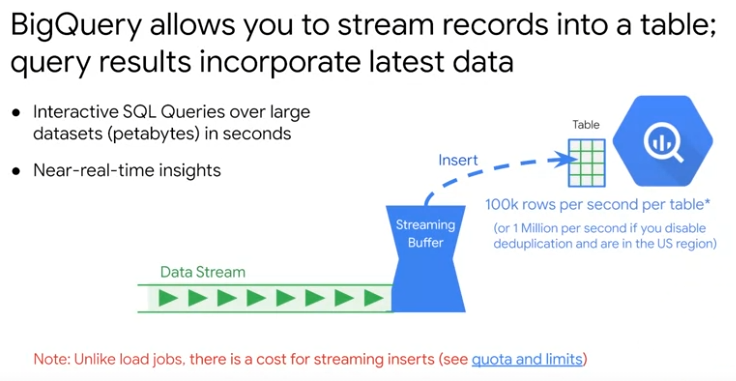


- INSERTING STREAMING DATA INTO A BIGQUERY TABLE

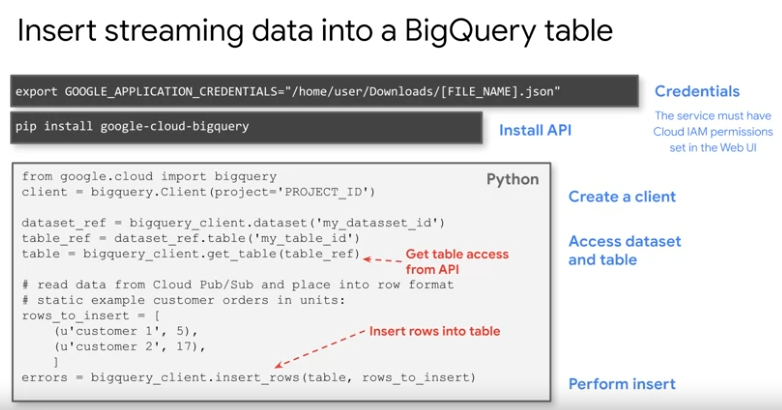

**High-Throughput Streaming with Cloud Bigtable**

- In BigQuery, the data that's streaming in is available in a matter of seconds, and sometimes you will want lower latency than that.

- sometimes you will want lower latency than that. You will want your information to be available in a matter of milliseconds, for example, or microseconds. 

- Bigtable handles high throughput data and at low latency and can be used for high performance applications

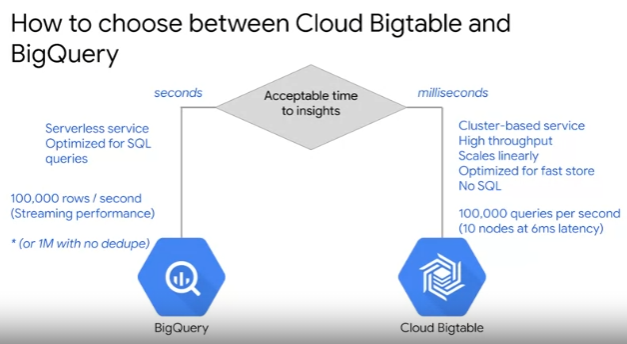

- Below are some considerations about when to/not to use Cloud Bigtable

- To use Cloud Bigtable effectively, you have to know a lot about your data and how it will be queried upfront. A lot of optimizations happen before you load data into Cloud Bigtable. Cloud Bigtable is ideal for applications that need very high throughput and scalability for non-structured key-value data, where each value is typically no larger than 10 megabytes.

- Not good for highly structured data, transaction data, small data, less than one terabytes and anything requiring SQL queries and SQL-like joins.

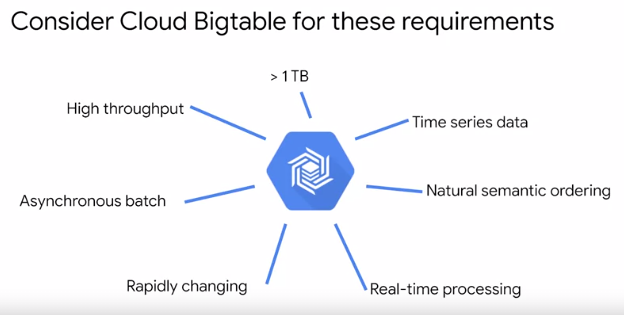


- Cloud Bigtable stores data in a file system called colossus. Colossus also contains data structures like tablets that are used to identify and manage the data, and metadata about the tablets is what it is stored on the VMs in Bigtable cluster itself.

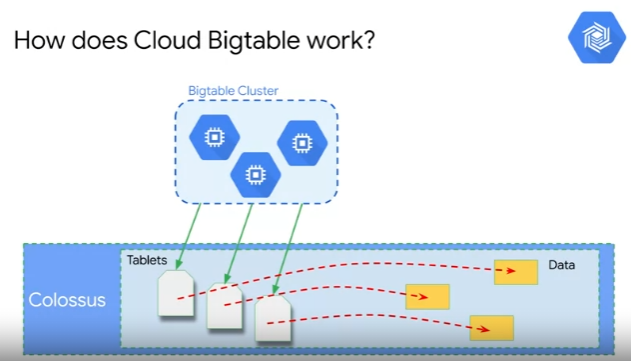

- Cloud Bigtable is a learning system. It detects hotspots, where a lot of activity is going through a single tablet and splits the table into two. It can also rebalance the processing by moving the pointer to a tablet to a different VM in the cluster. So it's best used cases with Big Data above 300 gigs and very fast access, but constant use over a longer period of time. This gives Cloud Bigtable a chance to learn about the traffic pattern and rebalance the tablets and the processing. 

- Bigtable is a cluster-based implementation, that means there are multiple machines which host Bigtable service and offer processing capabilities.

- If one of the machines (nodes) fail, the processing won't be affected and data won't be lost as Bigtable is a managed service and a=is fault tolerant

- In case of a node's failure, only pointers to the actual data will be lost. Actual data will be available in colossus. So a new replacement node will come up and it will be provided with a fresh copy of pointers or metadata which was handled by faulty node.

- Colossus maintains three replicas by default to provide durability.



**How is data stored in Bigtable**

- To begin with, it is just a table with rows and columns. However, unlike other table-based data systems like spreadsheets or SQL databases, Cloud Bigtable has only one index, that index is called as row key. There are no alternate indexes or secondary indexes, and when data is entered, it is organized lexicographically by the row key.

- In Cloud Bigtable, the first thing we must abandon in our design is SQL, that is a standard of all the operations are database can perform. To speed things up, we will drop most of them and build up from a minimal set of operations. That is why Cloud Bigtable is called a NoSQL database.


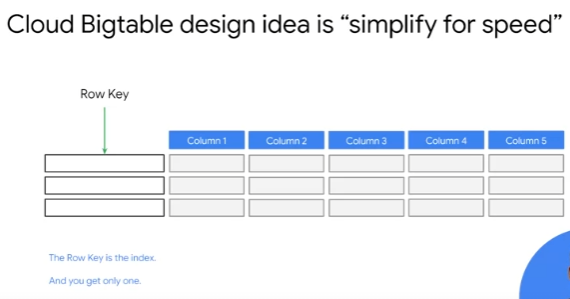

- to get the best performance with the design of the Cloud Bigtable service, you need to get your data in order first, if possible, and you need to select or construct a Row Key that minimizes sorting, and searching, and turns your most common queries into scans.

- Below is an exmaple of world flight data by capturing data baout the airplane, its capacity and orgin and destination

- in the first two example, independent columns are used as row index while in the third example an additinal column is constrcuted to combine the origin and arrival data as row index. this allows all the flight orignation from the same airport to be grouped together and sorted by arrival date which can increase performance of most used query which in this case is: "all flights originating from a particualr airport and filetered on arrival date"

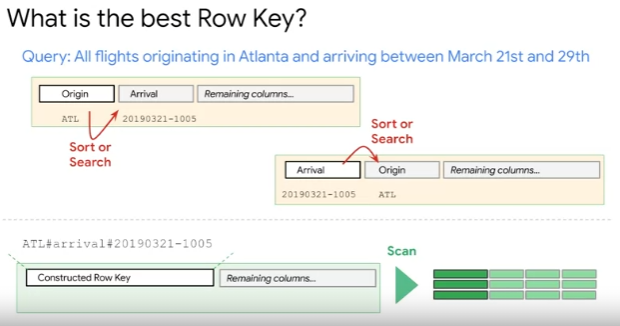

- Cloud Bigtable also provide column families. By accessing the column family, you can pull some of the data you need without pulling all of the data from the row, or having to search for it and assembling. This makes access more efficient.

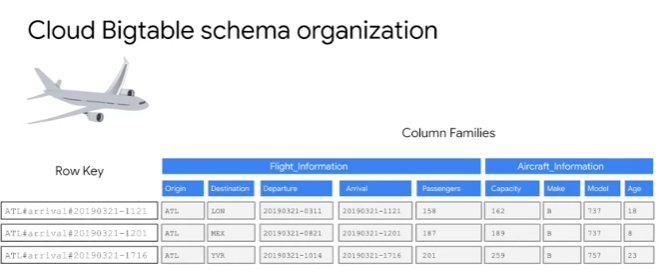

- When you delete data, the row is marked for deletion, and skipped during subsequent processing. It is not immediately removed.

- If you want to make a change to data, the new row is appended sequentially to the end of the table, and the previous version is marked for deletion

- Periodically, Cloud Bigtable compacts the table, removing rows marked for deletion, and reorganizing the data for read and write efficiency.

- Optimizing data organization for performance

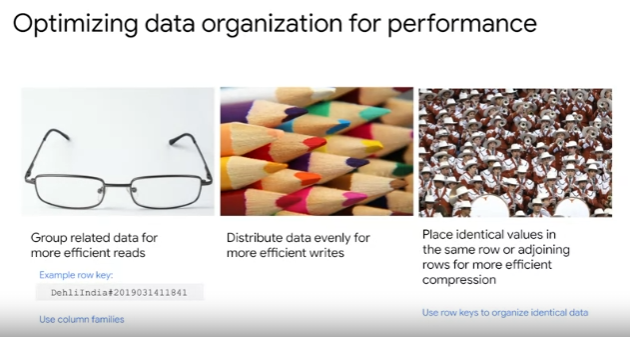

- Cloud Bigtable periodically rewrites your table to remove deleted entries, and to reorganize your data so that reads and writes are more efficient. It tries to distribute reads and writes equally across all Cloud Bigtable nodes. In this example, A, B, C, D, E are not data, but rather pointers or references and cache, which is why re-balancing is not time-consuming. We are just moving pointers. Actual data is in tablets in Colossus file system.

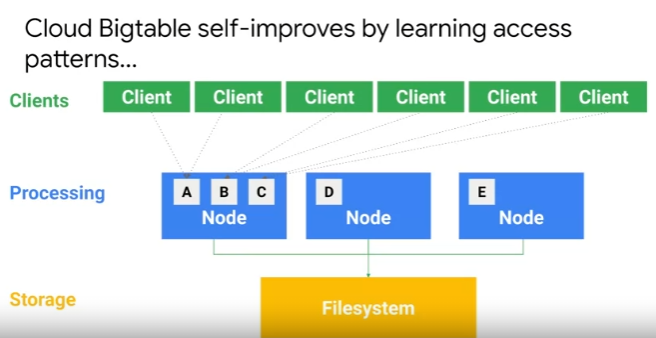

**Optimizing Cloud Bigtable Performance**

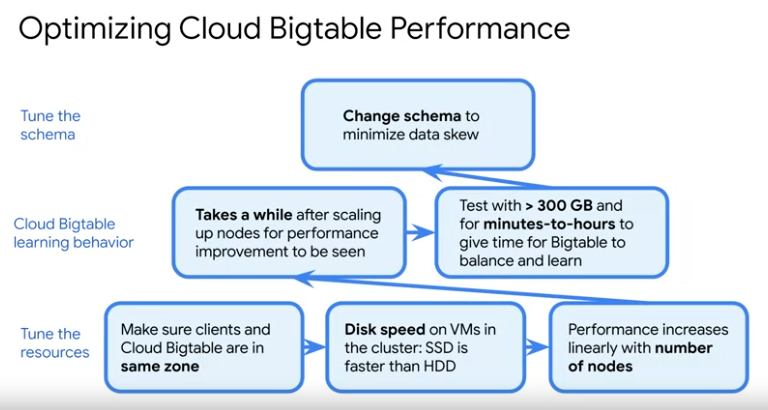

- Cloud Bigtable takes time to process cells within rows. So if there are fewer cells within a row, it would generally provide better performance than most cells. Finally, selecting the right row keys critical. Rows are sorted lexicographically. The goal when optimizing for streaming, is to avoid creating hotspots when writing, which would cause Cloud Bigtable to have a split tablets and adjust loads. To accomplish that, you want the data to be evenly distributed as possible. Reading delays, adding to processing delays leads to response time. 

- Besides high-throughput, you also want to make sure your data is highly available. Replication of Cloud Bigtable enables you to increase the availability and durability of your data by copying it across multiple regions or multiple zones within the same region.


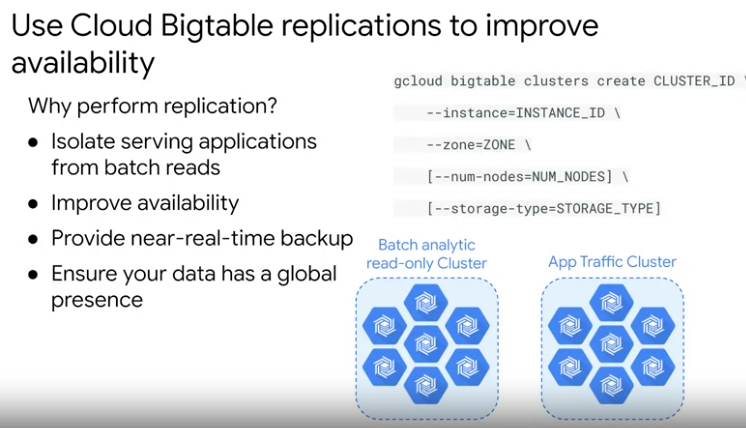

**GIS (Geographic Information Systems) Functions**

- Bigquery supports GIS functions to gain location based insights from data using SQL 

- To illustrat the use of these funtioncs, we will use examples

- example 1: Suppose we need to find the average speed of bikes betwoon the bike pickup station and bike drop off station. We are given two tables, cycle_hire which contains trip info and cycle_station which contain station info as follows

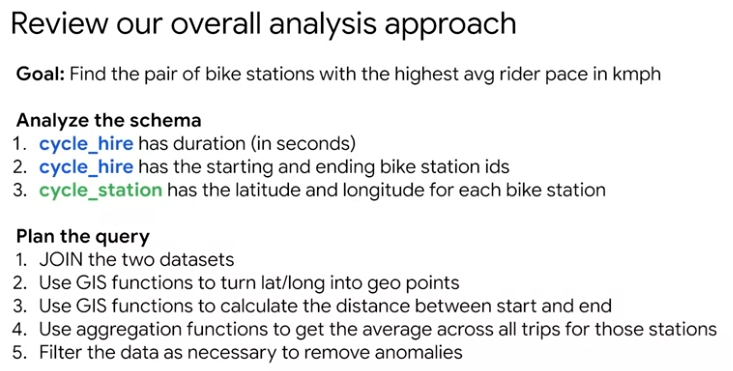

In [ ]:
--query to get all required info in 1 table is below

SELECT
  STRUCT(start_stn.name,
    start_stn.longitude,
    start_stn.latitude,
    start_stn.install_date) AS starting,
  STRUCT(end_stn.name,
    end_stn.longitude,
    end_stn.latitude,
    end_stn.install_date) AS ending,
  STRUCT(rental_id,
    bike_id,
    duration,
    start_date,
    end_date) AS bike_id
FROM
  `bigquery-public-data.london_bicycles.cycle_stations` AS start_stn
LEFT JOIN
  `bigquery-public-data.london_bicycles.cycle_hire` AS b
ON
  start_stn.id = b.start_station_id
LEFT JOIN
  `bigquery-public-data.london_bicycles.cycle_stations` AS end_stn
ON
  end_stn.id = b.end_station_id

- below is result of query above. ou can see how putting the columns for each table in a STRUCT gives us a nice prefix in the column name. So it's super clear that starting dot longitude is different from ending dot longitude. This process of joining together many tables into a single table is called denormalization. It's often a great way to store data for fast retrieval from BigQuery without having to do those joins each time. It's also highly performant because BigQuery stores data in a columnar format instead of a record format, which means you're not punished for having super wide schemas.

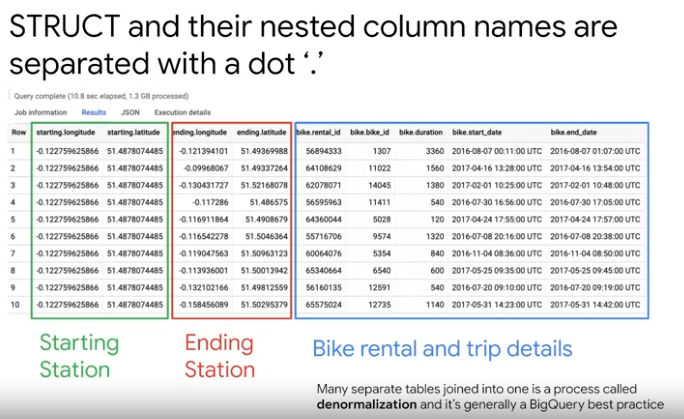

- now that ll the info we need is in a single table, we can use the GIS functions to calculate the distance between to long/lat points

- to do this, we use the ST_DISTANCE() GIS function that takes the long/lat coordinates of two point and outputs the distance between them in meters as in the example below (ST stands for "Spatial Type" and many GIS functions will start with these letters)

In [ ]:
SELECT
ST_DISTANCE(
    ST_GEOGPOINT(-0.122759625866, 51.4578074485),
    ST_GEOGPOINT(-0.121394101, 51.49369988)
) AS distnace_meters

- Assuming we have the distances calculated, the final query would like like below

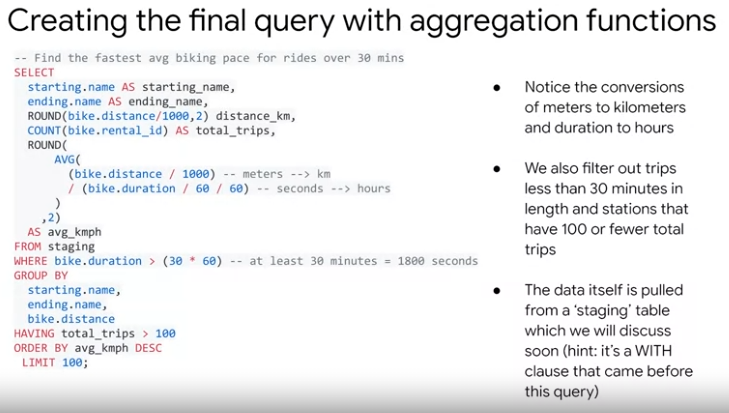

In [ ]:
SELECT
starting.name AS startig_name,
ending.name AS ending_name,
ROUND(bike.distance/1000) AS distance_km,
COUNT(bike.rental_id) AS total_trips,
ROUND(
    AVG(
        (bike.distance/1000) / 
        (bike.duration /3600)
    )
,2) --calculated kmph to two decimal points
AS avg_kmph
FROM staging
WHERE bike.duration > (30 *60)
GROUP BY
  starting.name,
  ending.name,
  bike.distance
HAVING total_trips > 100
ORDER BY avg_kmph DESC
LIMIT 100

In [ ]:
-- full query is below

WITH staging AS (
    SELECT
  STRUCT(start_stn.name,
    ST_GEOGPOINT(start_stn.longitude, start_stn.latitude) AS point,
    start_stn.longitude,
    start_stn.latitude,
    start_stn.install_date) AS starting,
  STRUCT(end_stn.name,
    ST_GEOGPOINT(end_stn.longitude, end_stn.latitude) AS point,
    end_stn.longitude,
    end_stn.latitude,
    end_stn.install_date) AS ending,
  STRUCT(rental_id,
    bike_id,
    duration,
    ST_DISTANCE(ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
    ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)) AS distance,
    ST_MAKELINE(ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
    ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)) AS trip_line,
    start_date,
    end_date) AS bike
FROM
  `bigquery-public-data.london_bicycles.cycle_stations` AS start_stn
LEFT JOIN
  `bigquery-public-data.london_bicycles.cycle_hire` AS b
ON
  start_stn.id = b.start_station_id
LEFT JOIN
  `bigquery-public-data.london_bicycles.cycle_stations` AS end_stn
ON
  end_stn.id = b.end_station_id)

SELECT
starting.name AS startig_name,
ending.name AS ending_name,
ROUND(bike.distance/1000) AS distance_km,
ST_UNION_AGG(bike.trip_line) AS trip_line,
COUNT(bike.rental_id) AS total_trips,
ROUND(
    AVG(
        (bike.distance/1000) / 
        (bike.duration /3600)
    )
,2) --calculated kmph to two decimal points
AS avg_kmph
FROM staging
WHERE bike.duration > (30 *60)
GROUP BY
  starting.name,
  ending.name,
  bike.distance
HAVING total_trips > 100
ORDER BY avg_kmph DESC
LIMIT 100

**Other GIS Functions**

- ST_MAKEPOLYGON

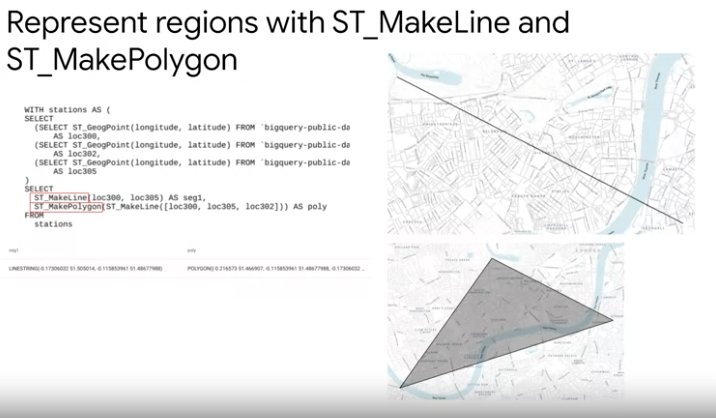

- ST_DWithin

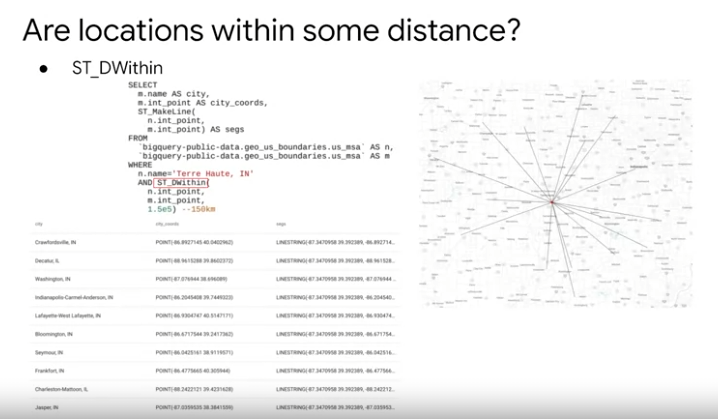

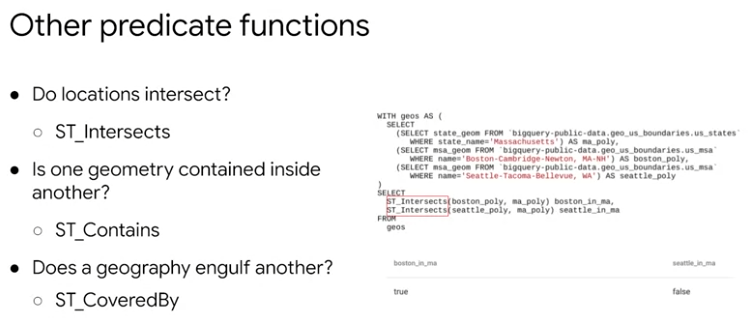

**Analytical window functions**

- Apply analytical window functions using another example related to the london bikes dataset. Here we try to find the stations with the fastest and slowest bke turnover times (time bike sat in station before being checked out again) as below

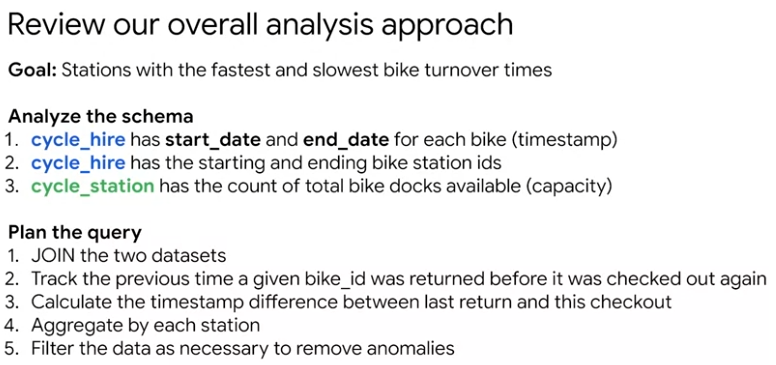

- Use lag/lead navigation functions to simplify query as below

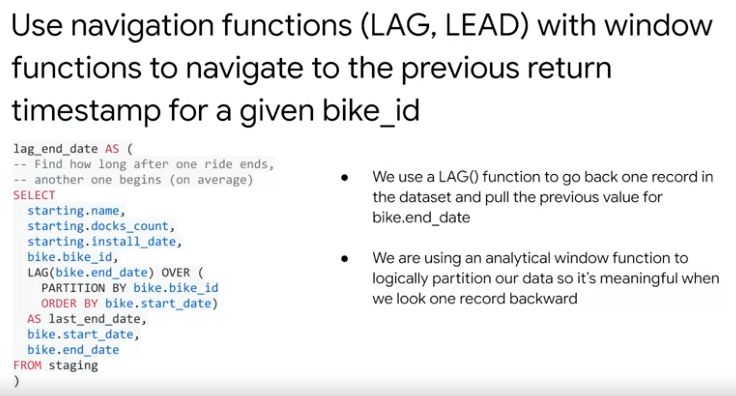

- the query above partitions the dataset by bike_id and sorts record by start_date and populates the last_end_date column with the end_date of the previous record. Below is the result of the query above

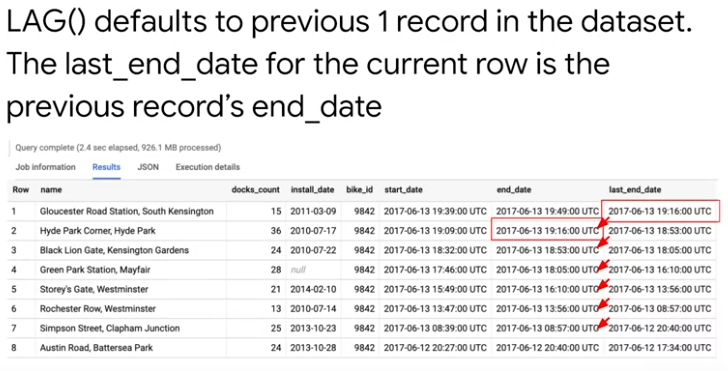

- we can then calculate the difference between the start and end date to get the time the bike sat idle before being checked out again and take the average of the idle time for each bike in each station

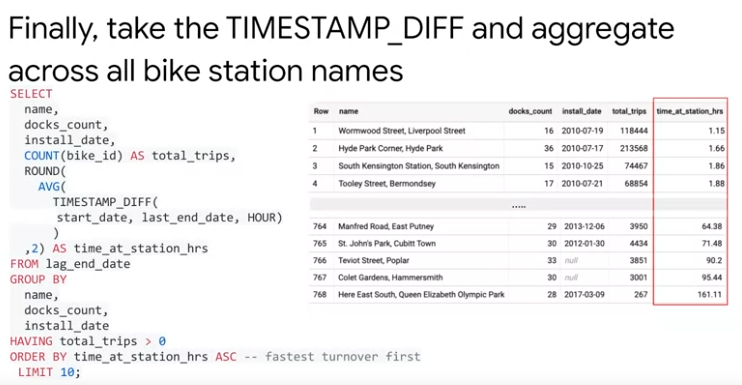

**Using ranking functions and Arrays**

- apply these functions to an example to demonstrate use. In this example we would to rank which bike needmost maintenance based on used time

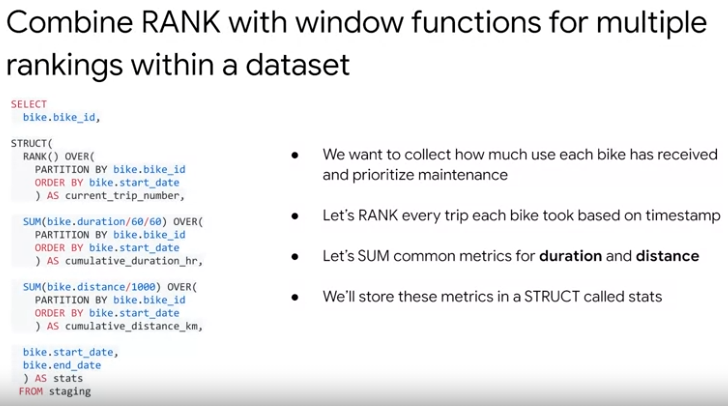

- result for query above shown below

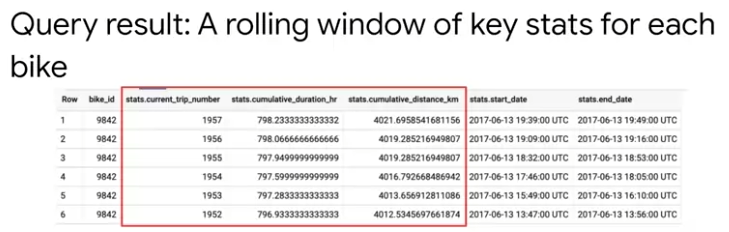

In [1]:
-- full query for above case below

WITH staging AS (
  SELECT 
    STRUCT(
      start_stn.name,
      ST_GEOGPOINT(start_stn.longitude, start_stn.latitude) AS point,
      start_stn.docks_count,
      start_stn.install_date
    ) AS starting,
    STRUCT(
      end_stn.name,
      ST_GEOGPOINT(end_stn.longitude, end_stn.latitude) AS point,
      end_stn.docks_count,
      end_stn.install_date
    ) AS ending,
    STRUCT(
      rental_id,
      bike_id,
      duration, -- seconds
      ST_DISTANCE(
        ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
        ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)
        ) AS distance, -- meters
      ST_MAKELINE(
        ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
        ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)
        ) AS trip_line, -- straight line (for GeoViz)
      start_date,
      end_date
    ) AS bike
  FROM `bigquery-public-data.london_bicycles.cycle_stations` AS start_stn
  LEFT JOIN `bigquery-public-data.london_bicycles.cycle_hire` AS b
  ON start_stn.id = b.start_station_id
  LEFT JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS end_stn
  ON end_stn.id = b.end_station_id
),
lag_end_date AS (
-- Find how long after one ride ends, another one begins (on average)
SELECT
  starting.name,
  starting.docks_count,
  starting.install_date,
  bike.bike_id,
  LAG(bike.end_date) OVER (
    PARTITION BY bike.bike_id 
    ORDER BY bike.start_date)
  AS last_end_date,
  bike.start_date,
  bike.end_date
FROM staging
)

SELECT
  name,
  docks_count,
  install_date,
  COUNT(bike_id) AS total_trips,
  ROUND(
    AVG(
      TIMESTAMP_DIFF(start_date, last_end_date, HOUR)
      )
  ,2) AS time_at_station_hrs
FROM lag_end_date
GROUP BY 
  name,
  docks_count,
  install_date
HAVING total_trips > 0
ORDER BY time_at_station_hrs ASC -- fastest turnover first
LIMIT 10;

SyntaxError: ignored

- using arrays to show granular details for every trip each bike took as well as sum of distnace and time each bike was used for as below

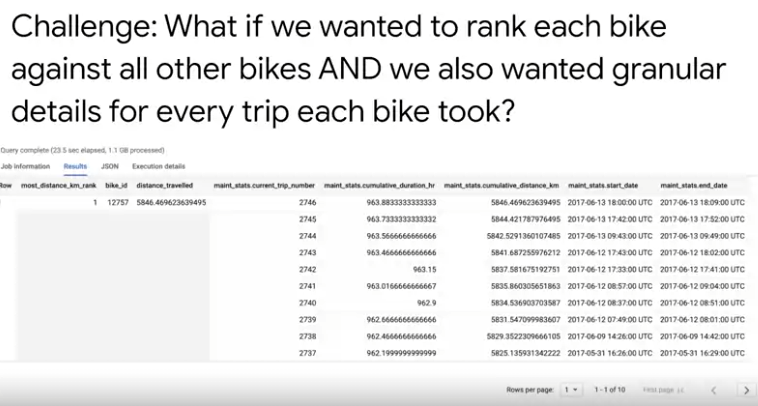



In [ ]:
WITH staging AS (
  SELECT 
    STRUCT(
      start_stn.name,
      ST_GEOGPOINT(start_stn.longitude, start_stn.latitude) AS point,
      start_stn.docks_count,
      start_stn.install_date
    ) AS starting,
    STRUCT(
      end_stn.name,
      ST_GEOGPOINT(end_stn.longitude, end_stn.latitude) AS point,
      end_stn.docks_count,
      end_stn.install_date
    ) AS ending,
    STRUCT(
      rental_id,
      bike_id,
      duration, -- seconds
      ST_DISTANCE(
        ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
        ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)
        ) AS distance, -- meters
      ST_MAKELINE(
        ST_GEOGPOINT(start_stn.longitude, start_stn.latitude),
        ST_GEOGPOINT(end_stn.longitude, end_stn.latitude)
        ) AS trip_line, -- straight line (for GeoViz)
      start_date,
      end_date
    ) AS bike
  FROM `bigquery-public-data.london_bicycles.cycle_stations` AS start_stn
  LEFT JOIN `bigquery-public-data.london_bicycles.cycle_hire` AS b
  ON start_stn.id = b.start_station_id
  LEFT JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS end_stn
  ON end_stn.id = b.end_station_id
)
-- Collect key stats for each bike on total usage
, maintenance_stats AS (
SELECT
  bike.bike_id,

STRUCT(
  RANK() OVER(
    PARTITION BY bike.bike_id
    ORDER BY bike.start_date
    ) AS current_trip_number,

  SUM(bike.duration/60/60) OVER(
    PARTITION BY bike.bike_id
    ORDER BY bike.start_date
    ) AS cumulative_duration_hr,

  SUM(bike.distance/1000) OVER(
    PARTITION BY bike.bike_id
    ORDER BY bike.start_date
    ) AS cumulative_distance_km,
    
  bike.start_date,
  bike.end_date
  ) AS stats
FROM staging
)
SELECT
  -- High level summary
  RANK() OVER(
    ORDER BY MAX(stats.cumulative_distance_km) DESC
    ) AS most_distance_km_rank,
  bike_id,
  MAX(stats.cumulative_distance_km) AS distance_travelled,
  -- Detail within array (show 10 most recent rides)
  ARRAY_AGG(stats ORDER BY stats.end_date DESC LIMIT 10) AS maint_stats
FROM maintenance_stats
GROUP BY bike_id
ORDER BY most_distance_km_rank LIMIT 10

**improivng query performance**

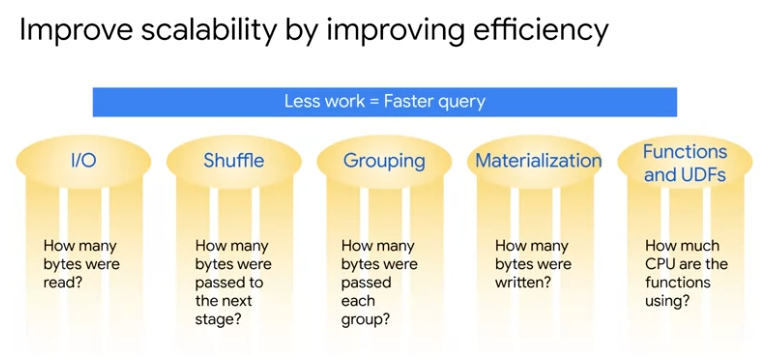

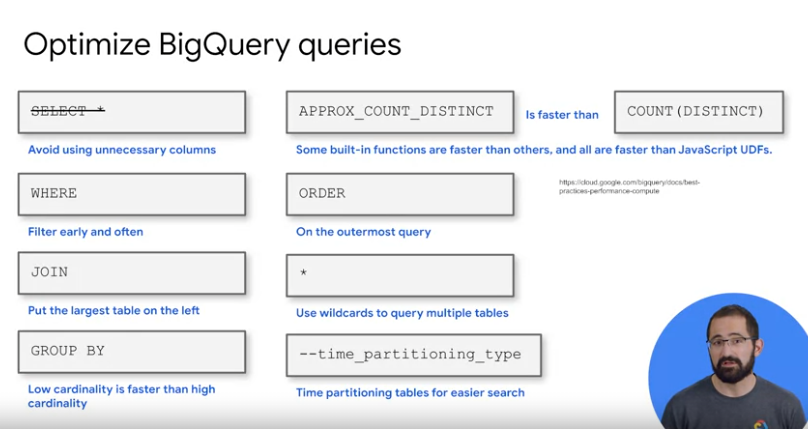